# Toxic Comment Classification
### Pujan Malavia

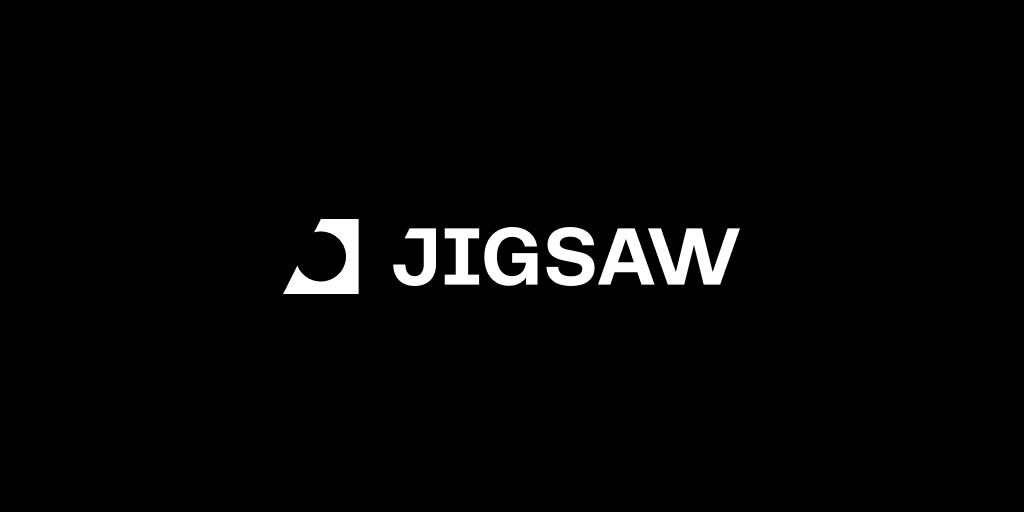

In [5]:
from IPython.display import display
from PIL import Image
path= "C:/Users/puj83/OneDrive/Portfolio/Toxic_Comments_Challenge/jigsaw.jpg"
display(Image.open(path))

### Link to Dataset:
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

### Abstract:

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive.

### Industry: 

Internet, Technology

### Company Information:

Jigsaw is a team of engineers, researchers and geopolitical experts who build products to support free expression and access to information, especially in repressive societies. We focus on the problems faced by people who live in unstable, isolated, or oppressive environments, including the billions of people who are coming online for the first time.

https://www.linkedin.com/company/jigsaw-google

https://jigsaw.google.com/

### Initial Dataset(s):

train.csv - the training set, contains comments with their binary labels

test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.

sample_submission.csv - a sample submission file in the correct format

test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

### Use Case:

Build a model to predict a probability for each of the six possible types of comment toxicity (toxic, severetoxic, obscene, threat, insult, identity, and hate)

### Tool:
Python (Jupyter Notebook)

### Data:

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. 

### Data Fields:

id: respective unique ID

comment_text: Unstructured text jargon

The types of toxicity are:

toxic

severe_toxic

obscene

threat

insult

identity_hate

In [6]:
!pip install wordcloud

### Import Libraries

In [85]:
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\puj83\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import Dataset(s) 

In [86]:
train = pd.read_csv('C:/Users/puj83/OneDrive/Portfolio/Toxic_Comments_Challenge/train.csv')
test = pd.read_csv('C:/Users/puj83/OneDrive/Portfolio/Toxic_Comments_Challenge/test.csv')
test_y = pd.read_csv('C:/Users/puj83/OneDrive/Portfolio/Toxic_Comments_Challenge/test_labels.csv')

In [87]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [88]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [90]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [91]:
train.shape

(159571, 8)

In [92]:
test.shape

(153164, 2)

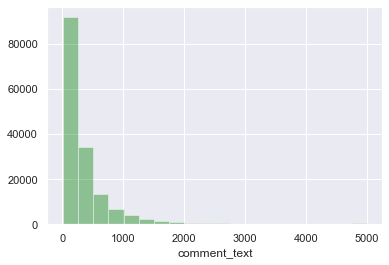

In [93]:
sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="green")

In [94]:
# Subsetting labels from the training data
train_labels = train[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = train_labels.sum()

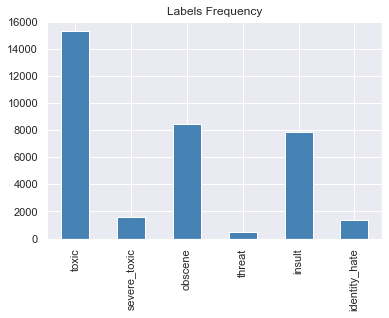

In [95]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

In [98]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [99]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [100]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

In [101]:
vector.get_feature_names()[0:20]

['aaa',
 'aap',
 'aardvark',
 'aaron',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abbas',
 'abbey',
 'abbott',
 'abbreviated',
 'abbreviation',
 'abc',
 'abcnews',
 'abd',
 'abducted',
 'abduction',
 'abdul']

In [50]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [51]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [52]:
# Calculating the cross validation F1 and Recall score for our 3 baseline models.
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [54]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'F1']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.482999,0.636562
1,MultinomialNB,severe_toxic,0.021938,0.042244
2,MultinomialNB,obscene,0.469167,0.622148
3,MultinomialNB,threat,0.000000,0.000000
4,MultinomialNB,insult,0.367020,0.511394
5,MultinomialNB,identity_hate,0.007832,0.015346
6,LogisticRegression,toxic,0.610500,0.731339
7,LogisticRegression,severe_toxic,0.256431,0.351530
8,LogisticRegression,obscene,0.636884,0.747278
9,LogisticRegression,threat,0.123316,0.206632


In [55]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [56]:
# Calculating the Hamming-loss F1 and Recall score for our 3 baseline models.
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [57]:
# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1']]

,Model,Label,Recall,F1
0,MultinomialNB,toxic,0.935196,0.930919
1,MultinomialNB,severe_toxic,0.994436,0.992145
2,MultinomialNB,obscene,0.962987,0.957902
3,MultinomialNB,threat,0.996702,0.995056
4,MultinomialNB,insult,0.960158,0.953453
5,MultinomialNB,identity_hate,0.988887,0.983408
6,LogisticRegression,toxic,0.935728,0.937031
7,LogisticRegression,severe_toxic,0.993123,0.992762
8,LogisticRegression,obscene,0.965957,0.964267
9,LogisticRegression,threat,0.996530,0.995725


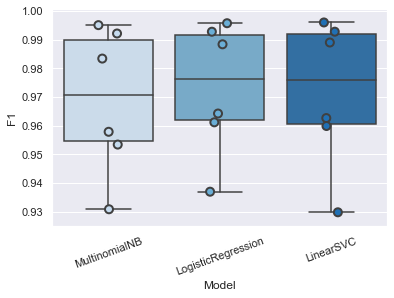

In [58]:
# Visualizing F1 score results through box-plot.
ax = sns.boxplot(x='Model', y='F1', data=methods, palette="Blues")
sns.stripplot(x='Model', y='F1', data=methods,
              size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Blues")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.show()

Plot for Multinomial Naive Bayes regression


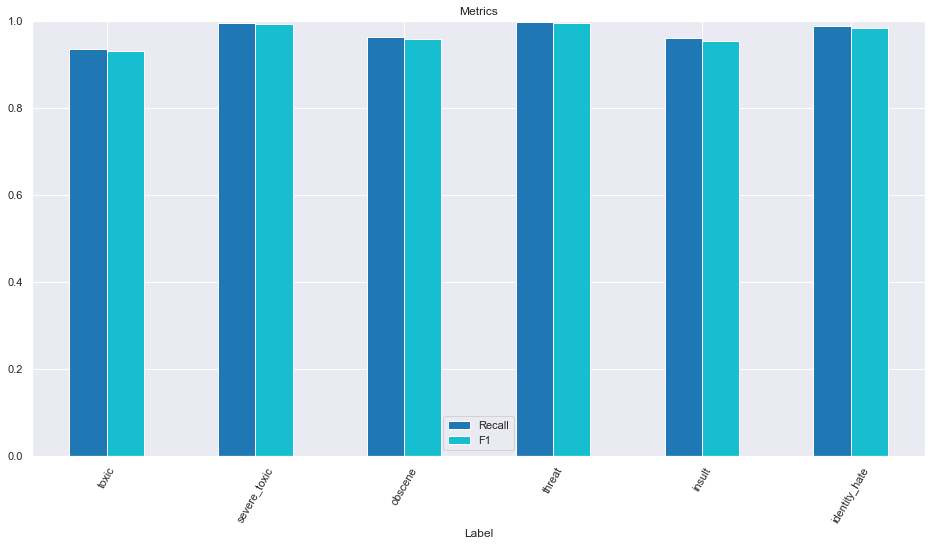

In [59]:
# Code to create bar graph of F1 and Recall across each label for Multinomial Naive Bayes
print("Plot for Multinomial Naive Bayes regression")
m2 = methods[methods.Model == 'MultinomialNB']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Logistic regression


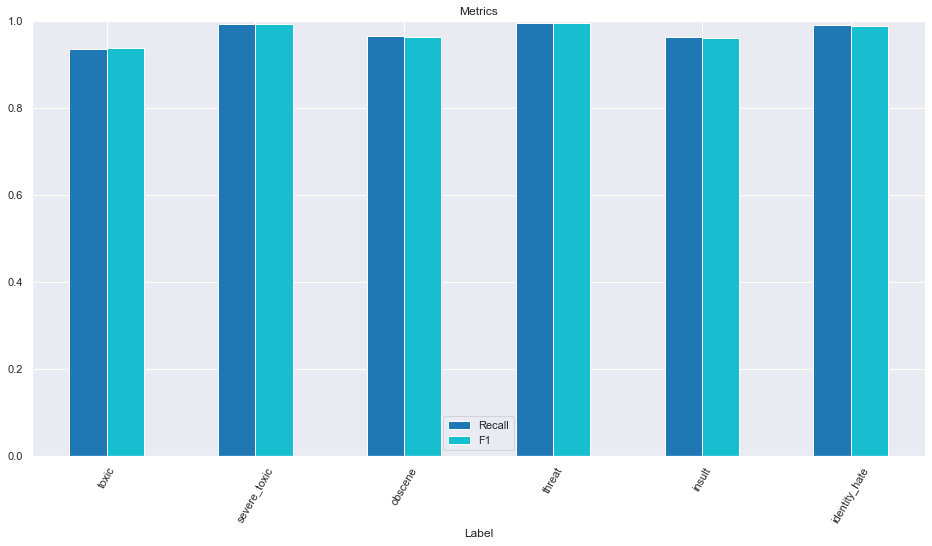

In [60]:
# Code to create bar graph of F1 and Recall across each label for Logistic regression
print("Plot for Logistic regression")
m2 = methods[methods.Model == 'LogisticRegression']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

Plot for Linear SVC


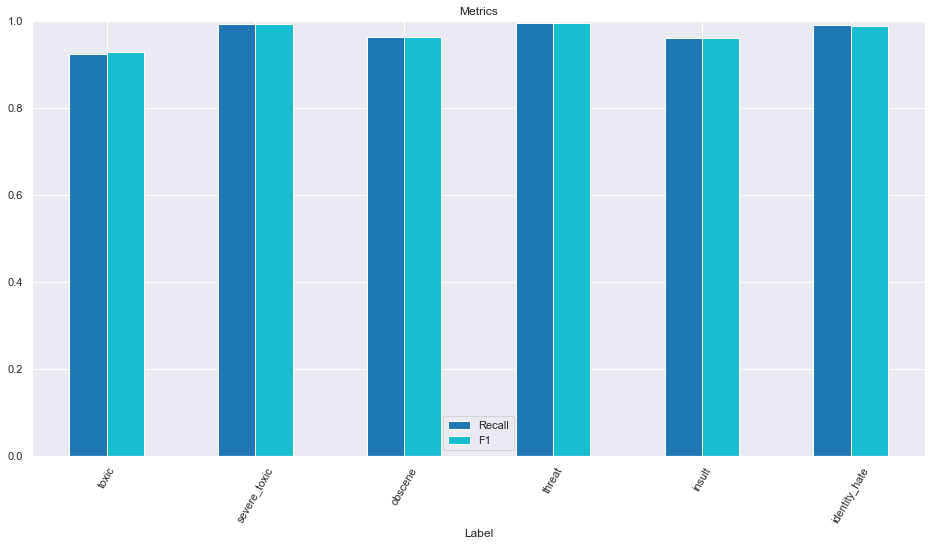

In [61]:
# Code to create bar graph of F1 and Recall across each label for Linear SVC
print("Plot for Linear SVC")
m2 = methods[methods.Model == 'LinearSVC']

m2.set_index(["Label"], inplace=True)
%matplotlib inline
m2.plot(figsize=(16, 8), kind='bar', title='Metrics',
        rot=60, ylim=(0.0, 1), colormap='tab10')

In [62]:
def drawConfusionMatrix(cm):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 16},
                cmap="Blues",
                fmt='.2f',
                linewidths=2,
                linecolor='steelblue',
                xticklabels=("Non-toxic", "Toxic"),
                yticklabels=("Non-toxic", "Toxic"))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.show()

In [63]:
def Matrix(label):
    """
    Plot Confusion matrix for each label and call function drawConfusionMatrix().
    """
    print(f"*************** {label} labelling ***************")
    labels = {"toxic": 0, "severe_toxic": 1, "obscene": 2,
              "threat": 3, "insult": 4, "identity_hate": 5}

    pos = labels[label]
    for i in range(pos, len(meth), 6):
        print()
        print(f"****  {meth['Model'][i]}  ***")
        cm = meth['Confusion_Matrix'][i]
        drawConfusionMatrix(cm)

Choose a class for the Confusion Matrix: toxic
*************** toxic labelling ***************

****  MultinomialNB  ***


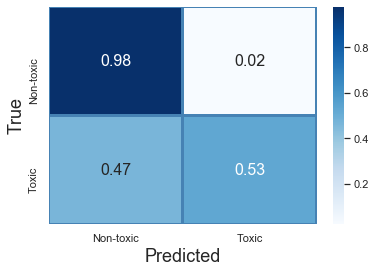


****  LogisticRegression  ***


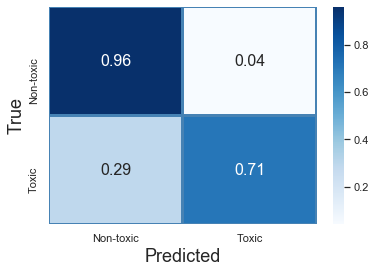


****  LinearSVC  ***


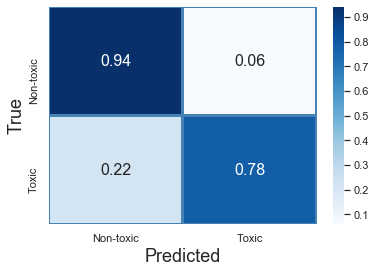

In [64]:
token = input('Choose a class for the Confusion Matrix: ')
Matrix(token.lower())

In [65]:
# Creating a dataframe to summarize Hamming-loss
hl1_df = pd.DataFrame(h1)
hl2_df = pd.DataFrame(h2)
hl3_df = pd.DataFrame(h3)

In [66]:
hammingloss = pd.concat([hl1_df, hl2_df, hl3_df])
hammingloss.columns = ['Model', 'Hamming_Loss']
hl = hammingloss.reset_index()
hl[['Model', 'Hamming_Loss']]

,Model,Hamming_Loss
0,MultinomialNB,0.026939
1,LogisticRegression,0.025670
2,LinearSVC,0.028476


In [67]:
pipe_lr = Pipeline([
    ('lr', LogisticRegression(class_weight="balanced"))
])

pipe_linear_svm = Pipeline([
    ('svm', LinearSVC(class_weight={1: 20}))
])

pipelines = [pipe_lr, pipe_linear_svm]

In [68]:
score_df = []
for pipe in pipelines:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    for label in test_labels:
        start = timer()
        pipe.fit(X_train, train[label])
        train_time = timer() - start
        predicted = pipe.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        recall_values.append(recall_score(
            test_y[test_y[label] != -1][label], predicted[test_y[label] != -1], average="weighted"))
        training_time.append(train_time)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]

    hamming_loss_score = hamming_loss(
        test_y[test_y['toxic'] != -1].iloc[:, 1:7], predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]
    score_df.append(val)

In [69]:
scores = pd.DataFrame(score_df,)
scores.columns = ['Model', 'F1', 'Recall', 'Hamming_Loss', 'Training_Time']
scores

,Model,F1,Recall,Hamming_Loss,Training_Time
0,LogisticRegression,0.947929,0.934066,0.065934,3.128763
1,LinearSVC,0.951508,0.941634,0.058366,7.572018


In [70]:
logistic_regression_classifier = LogisticRegression()

parameter_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  'class_weight': [None, 'balanced']}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(logistic_regression_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'class_weight': None, 'solver': 'liblinear'}


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
svm_classifier = LinearSVC()

parameter_grid = {'class_weight': [None, 'balanced'],
                  'C': [1, 5, 10]}

cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(svm_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           scoring='f1')

grid_search.fit(X_train, train['toxic'])

print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best parameters: {'C': 1, 'class_weight': None}


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [72]:
svm_clf = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                    intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                    multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                    verbose=0)

lr_clf = lr_clf = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                     intercept_scaling=1, max_iter=100, multi_class='ovr',
                                     n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
                                     tol=0.0001, verbose=0, warm_start=False)

tunned_model_score_df = []
for model in [svm_clf, lr_clf]:
    f1_values = []
    recall_values = []
    hl = []
    training_time = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        start = timer()
        model.fit(X_train, train[label])
        training_time.append(timer() - start)
        predicted = model.predict(X_test)
        predict_df[label] = predicted

        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, sum(training_time)]

    tunned_model_score_df.append(val)

In [73]:
tunned_scores = pd.DataFrame(tunned_model_score_df,)
tunned_scores.columns = ['Model', 'F1',
                         'Recall', 'Hamming_Loss', 'Traing_Time']
tunned_scores

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,LinearSVC,0.971706,0.971524,0.028476,5.681984
1,LogisticRegression,0.973227,0.974330,0.025670,17.232885


In [74]:
ab_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
xgb_clf = xgb.XGBClassifier()
boosting_models = [ab_clf, gb_clf, xgb_clf]

In [75]:
boosting_score_df = []
for model in boosting_models:
    f1_values = []
    recall_values = []
    training_time = []
    hloss = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for idx, label in enumerate(test_labels):
        start = timer()
        model.fit(X_train, train[label])
        predicted = model.predict(X_test)
        training_time.append(timer() - start)
        predict_df[label] = predicted
        f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                                  predicted[test_y[label] != -1],
                                  average="weighted"))
        recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                          predicted[test_y[label] != -1],
                                          average="weighted"))
        name = model.__class__.__name__

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

    val = [name, mean(f1_values), mean(recall_values),
           hamming_loss_score, mean(training_time)]

    boosting_score_df.append(val)

In [76]:
boosting_score = pd.DataFrame(boosting_score_df,)
boosting_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Traing_Time']
boosting_score

,Model,F1,Recall,Hamming_Loss,Traing_Time
0,AdaBoostClassifier,0.967605,0.969771,0.030229,33.678494
1,GradientBoostingClassifier,0.969156,0.971782,0.028218,166.796841
2,XGBClassifier,0.972642,0.973103,0.026897,43.623366


In [77]:
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf),
                                            ('svm', svm_clf),
                                            ('xgb', xgb_clf)], voting='hard')
ensemble_score_df = []
f1_values = []
recall_values = []
hl = []
training_time = []

predict_df = pd.DataFrame()
predict_df['id'] = test_y['id']
for label in test_labels:
    start = timer()
    ensemble_clf.fit(X_train, train[label])
    training_time.append(timer() - start)
    predicted = ensemble_clf.predict(X_test)
    predict_df[label] = predicted
    f1_values.append(f1_score(test_y[test_y[label] != -1][label],
                              predicted[test_y[label] != -1],
                              average="weighted"))
    recall_values.append(recall_score(test_y[test_y[label] != -1][label],
                                      predicted[test_y[label] != -1],
                                      average="weighted"))
    name = 'Ensemble'

hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                  predict_df[test_y['toxic'] != -1].iloc[:, 1:7])

val = [name, mean(f1_values), mean(recall_values),
       hamming_loss_score, mean(training_time)]
ensemble_score_df.append(val)


# printing the values
ensemble_score = pd.DataFrame(ensemble_score_df,)
ensemble_score.columns = ['Model', 'F1',
                          'Recall', 'Hamming_Loss', 'Training_Time']
ensemble_score

,Model,F1,Recall,Hamming_Loss,Training_Time
0,Ensemble,0.973258,0.973947,0.026053,45.179475


In [78]:
label = 'toxic'
lr = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
               intercept_scaling=1, loss='squared_hinge', max_iter=1000,
               multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
               verbose=0)
lr.fit(X_train, train[label])
Toxic_LR = lr.predict(X_test)
test_combined = pd.concat([test, test_y], axis=1)

In [79]:
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text
commentCheck.shape

(1347,)

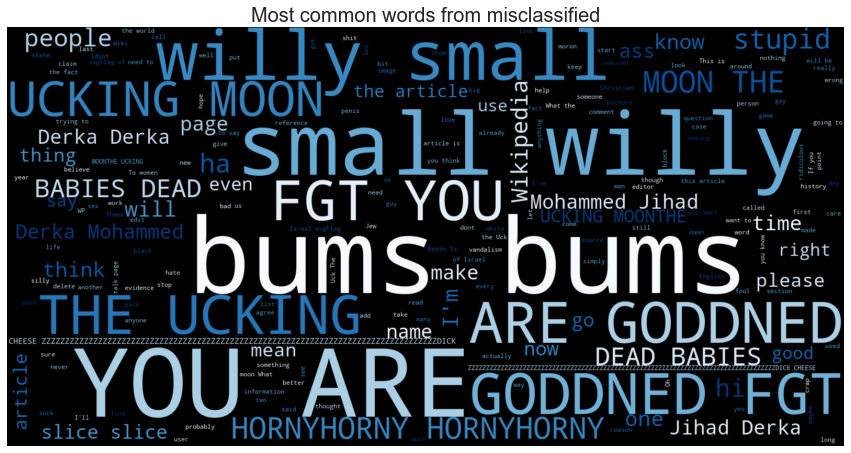

In [80]:
# extract wrongly classified comments
commentCheck = test_combined[(test_combined.toxic == 1) & (
    Toxic_LR == 0)].comment_text

neg_Check = pd.Series(commentCheck).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,
                      max_font_size=200).generate(neg_Check)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title("Most common words from misclassified", size=20)
plt.show()

In [81]:
wrongWords = tokenize(neg_Check)
stop_words = stopwords.words('English')
wrongWords = [w for w in wrongWords if w not in stop_words]
cntr = Counter(wrongWords)
cntr.most_common(20)

[('bum', 352),
 ('ucking', 253),
 ('small', 244),
 ('willy', 238),
 ('goddned', 226),
 ('fgt', 226),
 ('moon', 200),
 ('like', 184),
 ('article', 184),
 ('hornyhorny', 174),
 ('stupid', 142),
 ('people', 142),
 ('derka', 140),
 ('dead', 134),
 ('know', 132),
 ('baby', 129),
 ('one', 122),
 ('wikipedia', 119),
 ('think', 116),
 ('would', 115)]

In [82]:
neg_text_train = train['comment_text'].str.cat(sep=' ')
cntr_train = Counter(tokenize(neg_text_train))
cntr_train.get('ucking')

5

In [83]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plot learning rate curve for the estimator with title, training data as X, 
    labels as y.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="steelblue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="olive",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\puj83\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

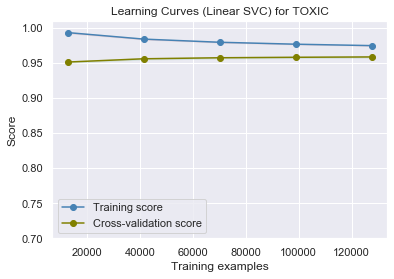

In [84]:
title = "Learning Curves (Linear SVC) for TOXIC"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
                      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
                      verbose=0)
plot_learning_curve(estimator, title, X_train,
                    train['toxic'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)